In [182]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
from qiskit import *

In [183]:
C_Image = np.zeros([2,2,3]) # (x,y,RGB)

C_Image[0,0,:] = (0,   128, 128)
C_Image[0,1,:] = (128, 0,   128)
C_Image[1,0,:] = (128, 128, 0)
C_Image[1,1,:] = (128, 128, 128)

In [184]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

C_Image = rgb2gray(C_Image)
C_Image

array([[ 89.728 ,  52.8512],
       [113.3952, 127.9872]])

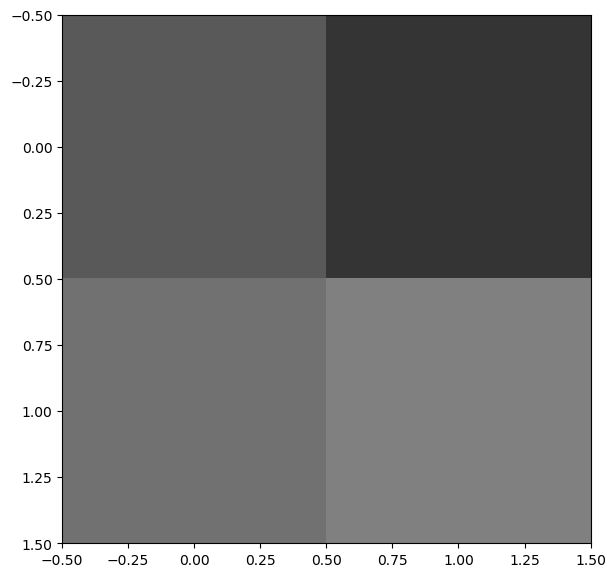

In [185]:
plt.imshow(C_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

In [186]:
W_Image = np.zeros([2,2,3]) # (x,y,RGB)

W_Image[0,0,:] = (34,   65, 232)
W_Image[0,1,:] = (255, 255,   255)
W_Image[1,0,:] = (228, 128, 54)
W_Image[1,1,:] = (54, 54, 54)

W_Image = rgb2gray(W_Image)
W_Image

array([[ 74.7656, 254.9745],
       [149.4412,  53.9946]])

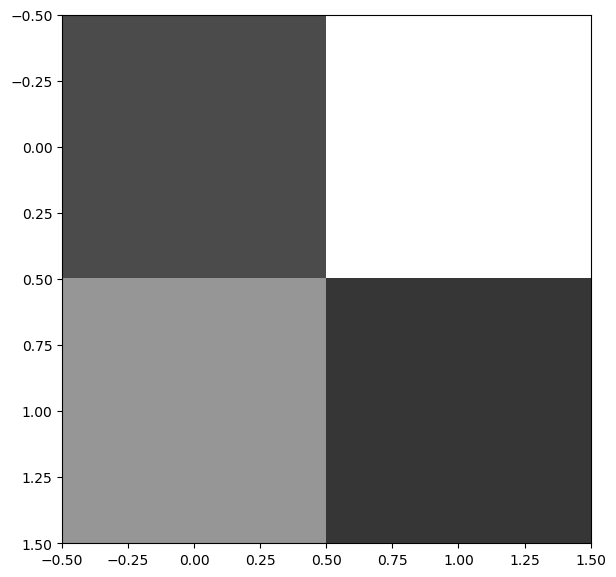

In [146]:
plt.imshow(W_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

In [187]:
def get_Coeff(Image, watermark=None):
    """ Function that takes in an Greyscale image matrix of any size and shape and returns qubit coefficients"""
    
    ## build in check sizes Image and watermark are the same
    Flatten_Image = np.reshape(Image, np.shape(Image)[0]*np.shape(Image)[1])
    
    #Theta_I = Flatten_Image*np.pi/255
    Theta_I = 2*np.arccos(np.sqrt(Flatten_Image/255))
                          
    if watermark is None:
        Theta_W = np.zeros(len(Theta_I))
    else:  
        Flatten_watermark = np.reshape(watermark, np.shape(watermark)[0]*np.shape(watermark)[1])
        Theta_W = 2*np.arccos(np.sqrt(Flatten_watermark/255))
        #Theta_W = Flatten_watermark*np.pi/255

    Coeff = np.stack((np.cos(Theta_I/2)*np.cos(Theta_W/2),
                       np.cos(Theta_I/2)*np.sin(Theta_W/2),
                       np.sin(Theta_I/2)*np.cos(Theta_W/2),
                       np.sin(Theta_I/2)*np.sin(Theta_W/2)))
    
    
    Coeff = np.ndarray.flatten(np.transpose(Coeff))
    
    return np.linalg.norm(Coeff), Coeff/np.linalg.norm(Coeff)

In [188]:
Norm, State_vector = get_Coeff(C_Image, W_Image)
State_vector

array([0.1605997 , 0.24935189, 0.2179618 , 0.33841399, 0.22761749,
       0.00227629, 0.44515759, 0.0044518 , 0.25524799, 0.21452326,
       0.28523577, 0.23972649, 0.16300024, 0.31449732, 0.16237858,
       0.31329786])

In [189]:
def initialise_state(desired_initial_state):
    n = int(round(np.log2(desired_initial_state.size)))
    
    # if 2**n != desired_initial_state.size:
        # don't run
    
    qc_init = QuantumCircuit(n)

    qc_init.initialize(desired_initial_state, range(n))
    return qc_init

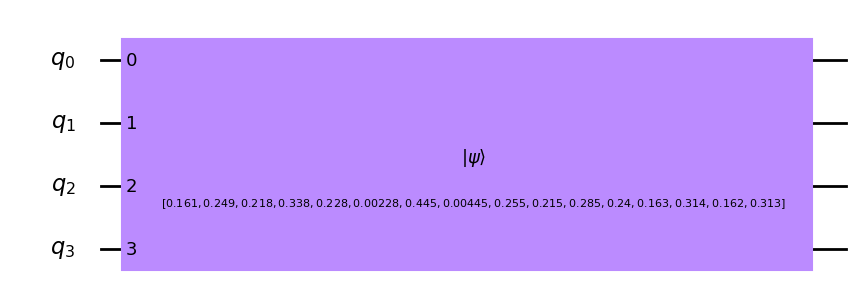

In [190]:
qc_init = initialise_state(State_vector)
qc_init.draw('mpl')

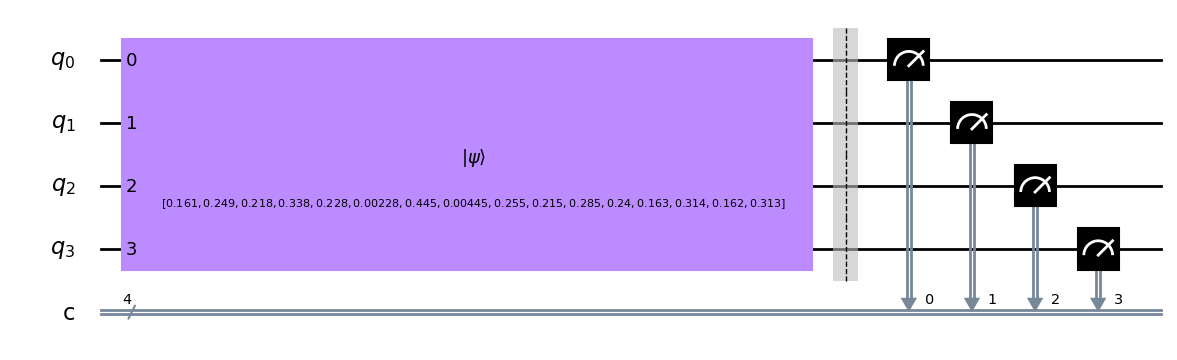

In [191]:
n = int(round(np.log2(State_vector.size)))
shots0 = 1000

# Create a Quantum Circuit
meas = QuantumCircuit(n, n)
meas.barrier(range(n))
# map the quantum measurement to the classical bits
meas.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc_init + meas

#drawing the circuit
qc.draw('mpl')

In [192]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc, backend_sim, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

{'0000': 31, '0001': 66, '0010': 37, '0011': 115, '0100': 63, '0110': 188, '1000': 60, '1001': 57, '1010': 75, '1011': 53, '1100': 27, '1101': 107, '1110': 30, '1111': 91}


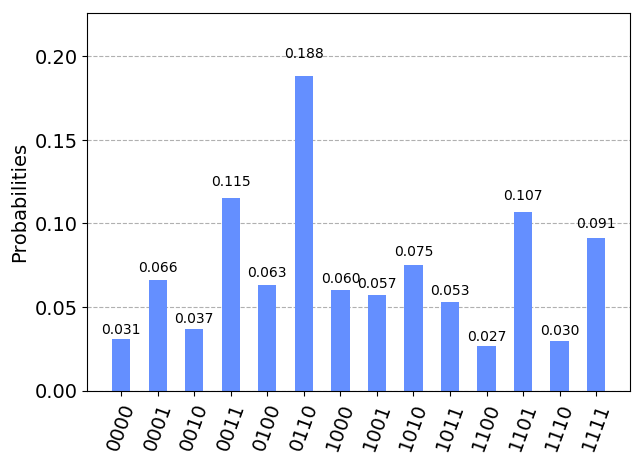

In [193]:
counts = result_sim.get_counts(qc)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [194]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)/shots0

print(probability_vector)

[0.031 0.066 0.037 0.115 0.063 0.    0.188 0.    0.06  0.057 0.075 0.053
 0.027 0.107 0.03  0.091]


In [25]:
# change to (p0000+p0001)/(p0000+p0001+p0010+p0011), np.reshape(probability_vector,[np.len(probability_vector)/4,4])

57.525560037819616

In [200]:
def get_Images(Norm, probability_vector):
    
    n = int(np.round(len(probability_vector)/4))
    c_Image = np.zeros(n)
    w_Image = np.zeros(n)
    
    ## Still need to vectorize this
    for i in range(n):
        c_Image[i] = Norm**2*(probability_vector[4*i]+probability_vector[4*i+1])*255#2*np.arccos(Norm*np.sqrt((probability_vector[4*i]+probability_vector[4*i+1])))/np.pi*255
        w_Image[i] = Norm**2*(probability_vector[4*i]+probability_vector[4*i+2])*255#2*np.arccos(Norm*np.sqrt((probability_vector[4*i]+probability_vector[4*i+2])))/np.pi*255
        
    c_Image = np.reshape(c_Image,[np.int(np.round(np.sqrt(n))),np.int(np.round(np.sqrt(n)))])
    w_Image = np.reshape(w_Image,[np.int(np.round(np.sqrt(n))),np.int(np.round(np.sqrt(n)))])
    return c_Image, w_Image

In [201]:
RC_Image, RW_Image = get_Images(Norm, probability_vector)
RC_Image

array([[ 98.94,  64.26],
       [119.34, 136.68]])

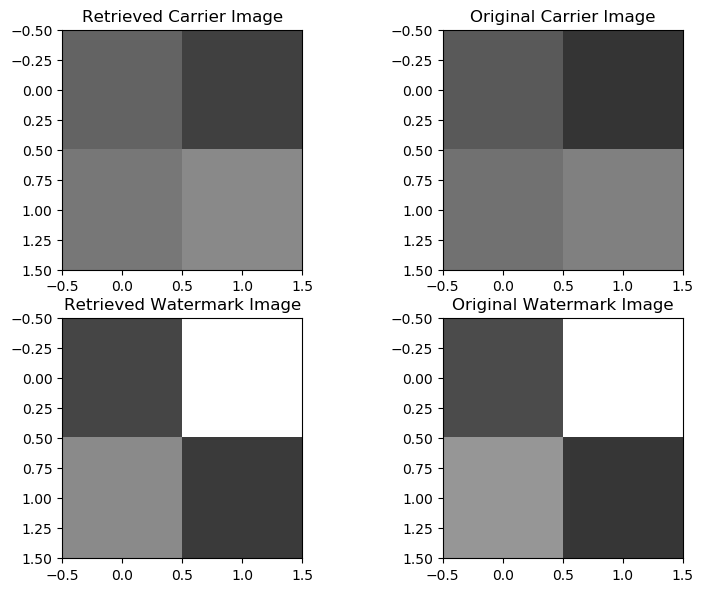

In [202]:
plt.rcParams['figure.figsize'] = [9, 7]
plt.rcParams['figure.dpi'] = 100

fig, axs = plt.subplots(2,2)

axs[0,0].imshow(RC_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axs[0,0].title.set_text('Retrieved Carrier Image')

axs[0,1].imshow(C_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axs[0,1].title.set_text('Original Carrier Image')

axs[1,0].imshow(RW_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axs[1,0].title.set_text('Retrieved Watermark Image')

axs[1,1].imshow(W_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axs[1,1].title.set_text('Original Watermark Image')

plt.show()

## Bigger Images

In [326]:
img_file = os.path.expanduser("IBM-logo.png")

In [327]:
img = cv2.imread(img_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
res = cv2.resize(img, dsize=(16, 16), interpolation=cv2.INTER_CUBIC)

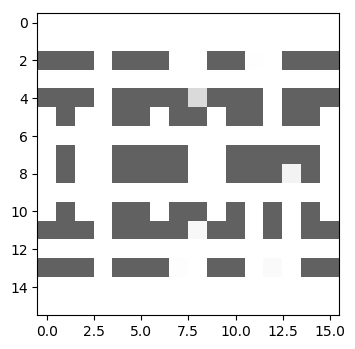

In [328]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100


W_Image = rgb2gray(res)
plt.imshow(C_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [329]:
img_file2 = os.path.expanduser("cat.png")

In [330]:
img2 = cv2.imread(img_file2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
res2 = cv2.resize(img2, dsize=(16, 16), interpolation=cv2.INTER_CUBIC)

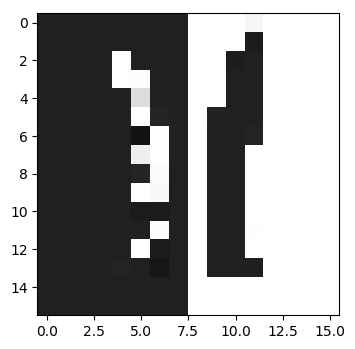

In [332]:
C_Image = rgb2gray(res2)
plt.imshow(C_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [251]:
Norm, State_vector = get_Coeff(C_Image, W_Image)
State_vector

array([2.22450387e-02, 5.84039179e-02, 2.22461511e-04, ...,
       6.24968749e-04, 6.24968749e-04, 6.25000000e-06])

In [210]:
qc_init = initialise_state(State_vector)
#qc_init.draw('mpl')

In [221]:
n = int(round(np.log2(State_vector.size)))
shots0 = 1000000

# Create a Quantum Circuit
meas = QuantumCircuit(n, n)
meas.barrier(range(n))
# map the quantum measurement to the classical bits
meas.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc_init + meas

#drawing the circuit
#qc.draw('mpl')

In [222]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc, backend_sim, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

In [223]:
counts = result_sim.get_counts(qc)

In [224]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)/shots0

#print(probability_vector)

In [225]:
RC_Image, RW_Image = get_Images(Norm, probability_vector)

[[ 32.9664   35.51232  33.55392  31.20384  32.24832  33.22752  33.68448
   34.9248  259.94496 254.2656  256.15872 247.99872 253.09056 254.52672
  253.48224 249.0432 ]
 [ 30.87744  32.90112  30.48576  32.9664   31.20384  32.57472  31.39968
   32.3136  250.74048 259.22688 261.31584  27.744   251.78496 256.68096
  258.44352 259.1616 ]
 [ 32.57472  30.94272  33.48864  31.85664 253.74336  31.39968  31.72608
   32.11776 256.28928 245.51808  28.46208  33.2928  256.35456 255.37536
  264.90624 256.09344]
 [ 30.81216  32.3136   32.50944  32.11776 246.30144 248.91264  32.70528
   33.6192  255.63648 256.09344  33.03168  31.85664 260.85888 250.74048
  262.81728 251.328  ]
 [ 32.64     31.53024  31.07328  33.03168  32.37888 221.03808  34.85952
   30.15936 261.05472 256.81152  30.61632  33.42336 253.6128  244.40832
  260.66304 257.33376]
 [ 31.79136  31.53024  30.0288   31.72608  32.3136  257.33376  37.92768
   32.18304 255.76704  32.3136   32.77056  33.55392 256.48512 251.328
  260.92416 257.79072]


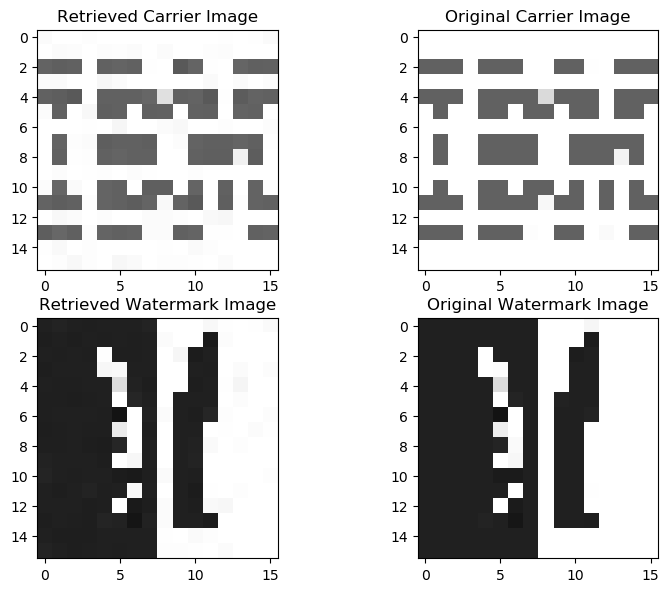

In [228]:
plt.rcParams['figure.figsize'] = [9, 7]
plt.rcParams['figure.dpi'] = 100

fig, axs = plt.subplots(2,2)

axs[0,0].imshow(RC_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axs[0,0].title.set_text('Retrieved Carrier Image')

axs[0,1].imshow(C_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axs[0,1].title.set_text('Original Carrier Image')

#RW_Image[np.where(np.isnan(RW_Image))]=0

axs[1,0].imshow(RW_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axs[1,0].title.set_text('Retrieved Watermark Image')

axs[1,1].imshow(W_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axs[1,1].title.set_text('Original Watermark Image')

print(RW_Image)
plt.show()

## Scrambling the watermark

In [284]:
C_Image = np.zeros([2,2,3]) # (x,y,RGB)

C_Image[0,0,:] = (0,   128, 128)
C_Image[0,1,:] = (128, 0,   128)
C_Image[1,0,:] = (128, 128, 0)
C_Image[1,1,:] = (128, 128, 128)

In [230]:
C_Image = rgb2gray(C_Image)
C_Image

array([[ 89.728 ,  52.8512],
       [113.3952, 127.9872]])

In [231]:
W_Image = np.zeros([2,2,3]) # (x,y,RGB)

W_Image[0,0,:] = (34,   65, 232)
W_Image[0,1,:] = (255, 255,   255)
W_Image[1,0,:] = (228, 128, 54)
W_Image[1,1,:] = (54, 54, 54)

W_Image = rgb2gray(W_Image)
W_Image

array([[ 74.7656, 254.9745],
       [149.4412,  53.9946]])

In [340]:
Norm, State_vector = get_Coeff(C_Image, W_Image)
State_vector

array([0.02144511, 0.00591597, 0.05630371, ..., 0.01990503, 0.00059245,
       0.00019906])

In [341]:
qc_init = initialise_state(State_vector)
#qc_init.draw('mpl')

In [342]:
n = int(round(np.log2(State_vector.size)))
shots0 = 100000

# Create a Quantum Circuit
meas = QuantumCircuit(n, n)
meas.barrier(range(n))
meas.cu3(-np.pi/4, 0, 0, 3, 0) 
meas.cu3(-np.pi/2, 0, 0, 2, 0) 
meas.cu3(-np.pi/4, 0, 0, 4, 0) 
 meas.cu3(-np.pi/2, 0, 0, 5, 0) 
# meas.cu3(-np.pi/3, 0, 0, 6, 0) 
# meas.cu3(-np.pi/2, 0, 0, 7, 0) 
# meas.cu3(-np.pi/4, 0, 0, 8, 0) 
# meas.cu3(-np.pi/2, 0, 0, 9, 0)

# map the quantum measurement to the classical bits
meas.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc_init + meas

#drawing the circuit
#qc.draw('mpl')

In [343]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc, backend_sim, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

In [344]:
counts = result_sim.get_counts(qc)

probability_vector = np.zeros(2**n)

int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily


for k in range(2**n):

    probability_vector[k] = int_counts.get(k, 0)/shots0


#print(probability_vector)

RC_Image, RW_Image = get_Images(Norm, probability_vector)



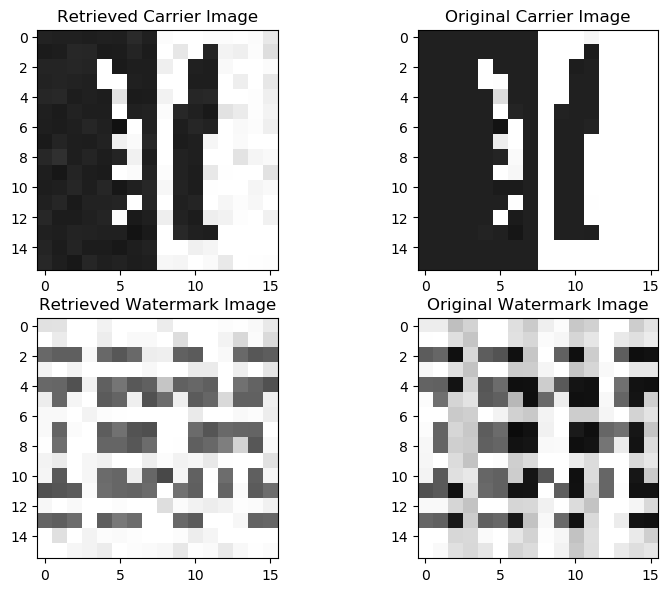

In [345]:
plt.rcParams['figure.figsize'] = [9, 7]
plt.rcParams['figure.dpi'] = 100

fig, axs = plt.subplots(2,2)

axs[0,0].imshow(RC_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axs[0,0].title.set_text('Retrieved Carrier Image')

axs[0,1].imshow(C_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axs[0,1].title.set_text('Original Carrier Image')

#RW_Image[np.where(np.isnan(RW_Image))]=0

axs[1,0].imshow(RW_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axs[1,0].title.set_text('Retrieved Watermark Image')

axs[1,1].imshow(W_Image/255, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
axs[1,1].title.set_text('Original Watermark Image')

plt.show()

In [339]:
W_Image = np.minimum(RW_Image,255*np.ones(len(RW_Image)))
W_Image

array([[236.9664, 236.9664, 190.6176, 211.5072, 255.    , 255.    ,
        222.6048, 202.368 , 238.9248, 251.328 , 199.7568, 208.2432,
        255.    , 255.    , 204.9792, 227.1744],
       [253.9392, 255.    , 222.6048, 197.1456, 255.    , 255.    ,
        224.5632, 214.7712, 250.0224, 245.4528, 214.1184, 229.1328,
        255.    , 233.0496, 223.9104, 235.6608],
       [ 92.0448, 102.4896,  16.32  , 215.424 ,  93.3504,  83.5584,
         16.32  , 197.7984, 255.    ,  97.92  ,  15.0144, 204.9792,
        255.    ,  94.0032,  14.3616,  17.6256],
       [247.4112, 255.    , 223.9104, 195.84  , 255.    , 255.    ,
        203.6736, 204.3264, 244.8   , 255.    , 197.1456, 214.1184,
        248.7168, 255.    , 231.0912, 230.4384],
       [ 99.2256,  97.92  ,  18.9312, 210.8544,  86.1696, 107.712 ,
         15.0144,  16.32  , 204.9792,  88.7808,  20.2368,  17.6256,
        255.    , 111.6288,  18.2784,  16.32  ],
       [251.328 , 110.976 , 212.8128, 226.5216,  90.0864,  96.6144,
       